## HW5
## Name: Surya Roshan Mugada
## USC ID: 6545904818
## Github : Roshan-99

References:

https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas

https://picnet.com.au/blog/xgboost-windows-x64-binaries-for-download/

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [1]:
import pandas as pd
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.tree import plot_tree
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import xgboost

### 1) a) Reading the data

In [2]:
columns=['Temperature','Nausea','Lumbar pain','Urine pushing','Micturition','Urethra issues','Inflammation','Nephritis']
data=pd.read_csv('../Data/diagnosis.data', encoding='utf-16', sep='\t', names=columns)

In [3]:
data['Temperature']=data['Temperature'].apply(lambda x:float(str(x).replace(',','.')))

In [4]:
label_encoder = preprocessing.LabelEncoder()
columns=data.columns
for col in ['Nausea','Lumbar pain','Urine pushing','Micturition','Urethra issues']:
    data[col]=label_encoder.fit_transform(data[col])

### 1) b) Building the decision tree and plotting it

In [5]:
tree_clf = DecisionTreeClassifier()
X,y=data.iloc[:,0:-2], data.iloc[:,-2:]
tree_clf.fit(X,y)

DecisionTreeClassifier()

In [6]:
data.iloc[:,-2:]

,Inflammation,Nephritis
0,no,no
1,yes,no
2,no,no
3,yes,no
4,no,no
...,...,...
115,no,yes
116,no,no
117,no,yes
118,no,yes


[Text(0.4, 0.9, 'Temperature <= 37.95\ngini = 0.493\nsamples = 120\nvalue = [[61, 59]\n[70, 50]]'),
 Text(0.2, 0.7, 'Lumbar pain <= 0.5\ngini = 0.222\nsamples = 60\nvalue = [[20, 40]\n[60, 0]]'),
 Text(0.1, 0.5, 'gini = 0.0\nsamples = 40\nvalue = [[0, 40]\n[40, 0]]'),
 Text(0.3, 0.5, 'gini = 0.0\nsamples = 20\nvalue = [[20, 0]\n[20, 0]]'),
 Text(0.6, 0.7, 'Lumbar pain <= 0.5\ngini = 0.355\nsamples = 60\nvalue = [[41, 19]\n[10, 50]]'),
 Text(0.5, 0.5, 'gini = 0.0\nsamples = 10\nvalue = [[10, 0]\n[10, 0]]'),
 Text(0.7, 0.5, 'Micturition <= 0.5\ngini = 0.236\nsamples = 50\nvalue = [[31, 19]\n[0, 50]]'),
 Text(0.6, 0.3, 'gini = 0.0\nsamples = 21\nvalue = [[21, 0]\n[0, 21]]'),
 Text(0.8, 0.3, 'Urine pushing <= 0.5\ngini = 0.226\nsamples = 29\nvalue = [[10, 19]\n[0, 29]]'),
 Text(0.7, 0.1, 'gini = 0.0\nsamples = 10\nvalue = [[10, 0]\n[0, 10]]'),
 Text(0.9, 0.1, 'gini = 0.0\nsamples = 19\nvalue = [[0, 19]\n[0, 19]]')]

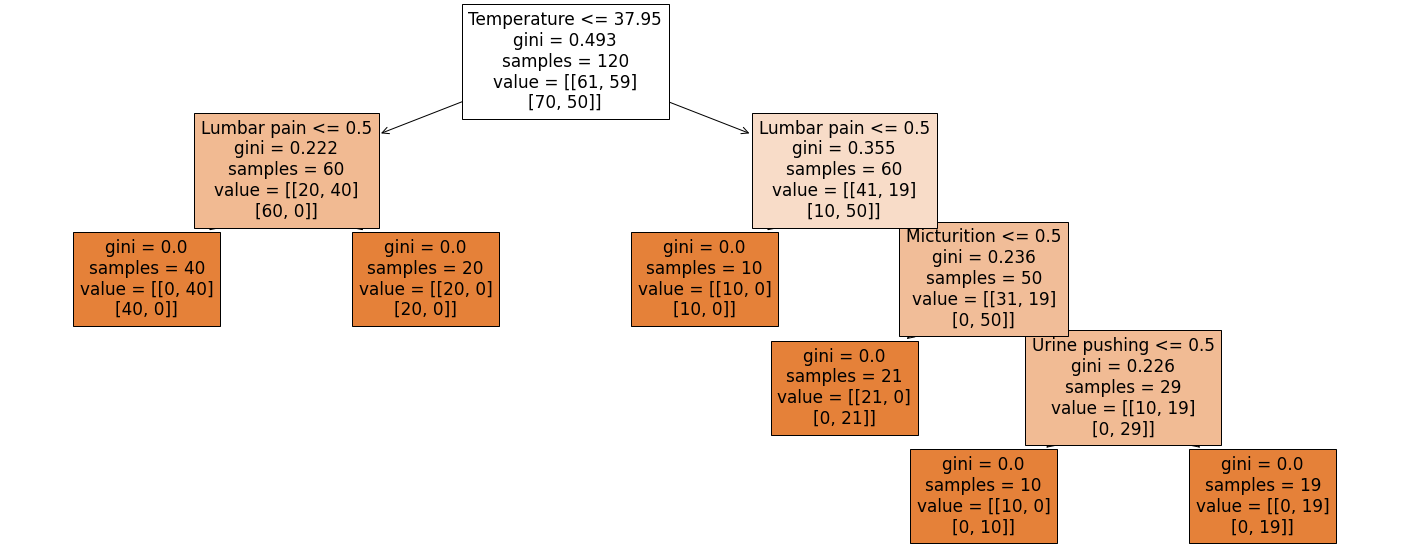

In [7]:
plt.figure(figsize=(25,10))
plot_tree(tree_clf,feature_names=columns,filled=True)

### 1) c) Decision tree into If-else rules

In [8]:
def tree_to_pseudo(tree, feature_names):
    """
    Outputs a decision tree model as if/then pseudocode

    Parameters:
    -----------
    tree: decision tree model
    The decision tree to represent as pseudocode
    feature_names: list
    The feature names of the dataset used for building the decision tree
    """

    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value
    
    def recurse(left, right, threshold, features, node, depth=0):
        indent = "  " * depth
        if (threshold[node] != -2):
            print(indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
            if left[node] != -1:
                recurse (left, right, threshold, features, left[node], depth+1)
                print(indent,"} else {")
                if right[node] != -1:
                    recurse (left, right, threshold, features, right[node], depth+1)
                print(indent,"}")
        else:
            print(indent,"return " + str(value[node]))

    recurse(left, right, threshold, features, 0)

In [9]:
tree_to_pseudo(tree_clf, data.columns)

 if ( Temperature <= 37.95000076293945 ) {
   if ( Lumbar pain <= 0.5 ) {
     return [[ 0. 40.]
 [40.  0.]]
   } else {
     return [[20.  0.]
 [20.  0.]]
   }
 } else {
   if ( Lumbar pain <= 0.5 ) {
     return [[10.  0.]
 [10.  0.]]
   } else {
     if ( Micturition <= 0.5 ) {
       return [[21.  0.]
 [ 0. 21.]]
     } else {
       if ( Urine pushing <= 0.5 ) {
         return [[10.  0.]
 [ 0. 10.]]
       } else {
         return [[ 0. 19.]
 [ 0. 19.]]
       }
     }
   }
 }


In [10]:
 data.iloc[:,-2:]

,Inflammation,Nephritis
0,no,no
1,yes,no
2,no,no
3,yes,no
4,no,no
...,...,...
115,no,yes
116,no,no
117,no,yes
118,no,yes


### 1) d) Cost complexity pruning to find minimal tree

In [11]:
#Cost complexity pruning
path = tree_clf.cost_complexity_pruning_path(X, y)

In [12]:
ccp_alphas=path['ccp_alphas']
ccp_alphas

array([0.        , 0.04908333, 0.07947222, 0.11111111, 0.20423611])

In [13]:
param_dict={'ccp_alpha':ccp_alphas}

In [14]:
for col in y.columns:
    y[col]=label_encoder.fit_transform(y[col])

In [15]:
y

,Inflammation,Nephritis
0,0,0
1,1,0
2,0,0
3,1,0
4,0,0
...,...,...
115,0,1
116,0,0
117,0,1
118,0,1


In [16]:
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_dict, cv=5, n_jobs=-1)
gridSearch.fit(X,y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': array([0.        , 0.04908333, 0.07947222, 0.11111111, 0.20423611])})

In [17]:
gridSearch.cv_results_

{'mean_fit_time': array([0.00678201, 0.00698128, 0.00578427, 0.00678201, 0.00757918]),
 'std_fit_time': array([0.00074589, 0.00154511, 0.00074597, 0.00146623, 0.00272125]),
 'mean_score_time': array([0.00478673, 0.00458856, 0.00379109, 0.00359049, 0.00418878]),
 'std_score_time': array([0.00074546, 0.00119748, 0.00039959, 0.00048825, 0.00074616]),
 'param_ccp_alpha': masked_array(data=[0.0, 0.04908333333333333, 0.07947222222222226,
                    0.1111111111111111, 0.204236111111111],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'ccp_alpha': 0.0},
  {'ccp_alpha': 0.04908333333333333},
  {'ccp_alpha': 0.07947222222222226},
  {'ccp_alpha': 0.1111111111111111},
  {'ccp_alpha': 0.204236111111111}],
 'split0_test_score': array([1.        , 1.        , 1.        , 0.54166667, 0.54166667]),
 'split1_test_score': array([1.  , 1.  , 1.  , 0.75, 0.  ]),
 'split2_test_score': array([0.75      , 0.66666667, 0.6666666

In [18]:
gridSearch.best_params_

{'ccp_alpha': 0.0}

In [19]:
pruned_tree_clf=DecisionTreeClassifier(ccp_alpha=gridSearch.best_params_['ccp_alpha'])
pruned_tree_clf.fit(X,y)

DecisionTreeClassifier()

[Text(0.4, 0.9, 'Temperature <= 37.95\ngini = 0.493\nsamples = 120\nvalue = [[61, 59]\n[70, 50]]'),
 Text(0.2, 0.7, 'Lumbar pain <= 0.5\ngini = 0.222\nsamples = 60\nvalue = [[20, 40]\n[60, 0]]'),
 Text(0.1, 0.5, 'gini = 0.0\nsamples = 40\nvalue = [[0, 40]\n[40, 0]]'),
 Text(0.3, 0.5, 'gini = 0.0\nsamples = 20\nvalue = [[20, 0]\n[20, 0]]'),
 Text(0.6, 0.7, 'Lumbar pain <= 0.5\ngini = 0.355\nsamples = 60\nvalue = [[41, 19]\n[10, 50]]'),
 Text(0.5, 0.5, 'gini = 0.0\nsamples = 10\nvalue = [[10, 0]\n[10, 0]]'),
 Text(0.7, 0.5, 'Nausea <= 0.5\ngini = 0.236\nsamples = 50\nvalue = [[31, 19]\n[0, 50]]'),
 Text(0.6, 0.3, 'gini = 0.0\nsamples = 21\nvalue = [[21, 0]\n[0, 21]]'),
 Text(0.8, 0.3, 'Urine pushing <= 0.5\ngini = 0.226\nsamples = 29\nvalue = [[10, 19]\n[0, 29]]'),
 Text(0.7, 0.1, 'gini = 0.0\nsamples = 10\nvalue = [[10, 0]\n[0, 10]]'),
 Text(0.9, 0.1, 'gini = 0.0\nsamples = 19\nvalue = [[0, 19]\n[0, 19]]')]

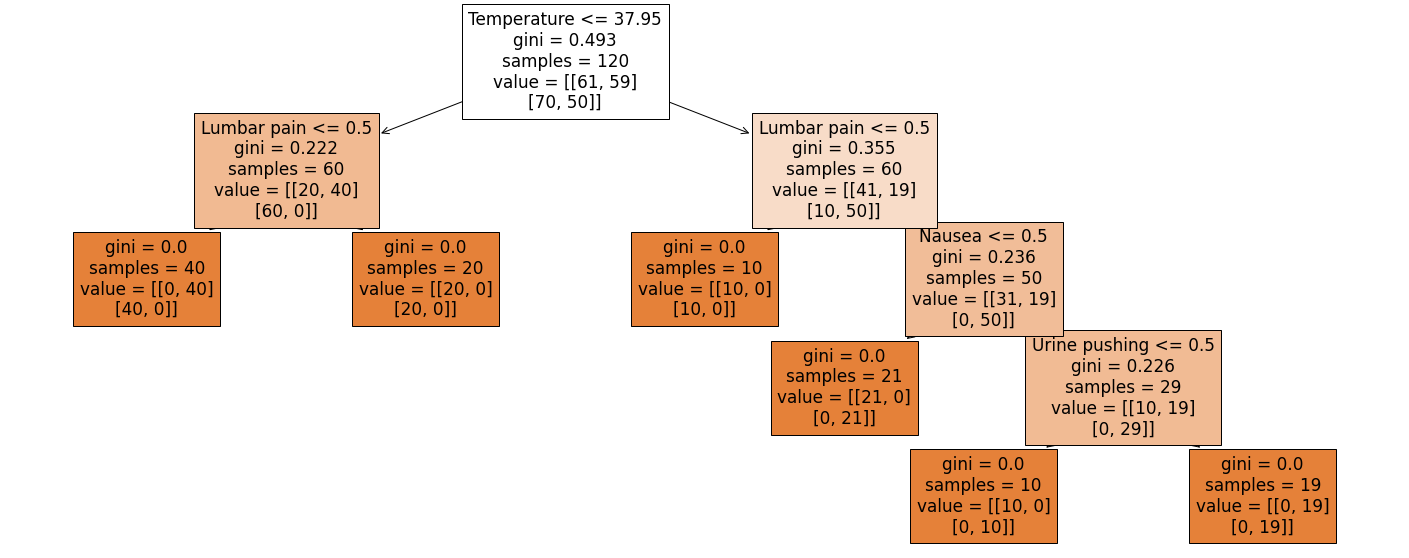

In [20]:
plt.figure(figsize=(25,10))
plot_tree(pruned_tree_clf,feature_names=columns,filled=True)

In [21]:
tree_to_pseudo(pruned_tree_clf,data.columns)

 if ( Temperature <= 37.95000076293945 ) {
   if ( Lumbar pain <= 0.5 ) {
     return [[ 0. 40.]
 [40.  0.]]
   } else {
     return [[20.  0.]
 [20.  0.]]
   }
 } else {
   if ( Lumbar pain <= 0.5 ) {
     return [[10.  0.]
 [10.  0.]]
   } else {
     if ( Nausea <= 0.5 ) {
       return [[21.  0.]
 [ 0. 21.]]
     } else {
       if ( Urine pushing <= 0.5 ) {
         return [[10.  0.]
 [ 0. 10.]]
       } else {
         return [[ 0. 19.]
 [ 0. 19.]]
       }
     }
   }
 }


## 2) Lasso and Boosting for regression

In [22]:
columns=[]
with open('../Data/communities_data_details.names') as f:
    for line in f:
        if '@attribute' in line:
            columns.append(line.split()[1])

In [23]:
len(columns)

128

In [24]:
full_data=pd.read_csv('../Data/communities.data',names=columns)

In [25]:
full_data

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,?,?,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,?,?,?,?,0.00,?,0.09
1990,6,?,?,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,?,?,?,?,0.00,?,0.45
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


### 2) b) Fixing missing values by replacing ? with np.nan and then finding mean along that column

In [26]:
def replace_with_nans(x):
    if x == '?':
        return np.nan
    else :
        return x
for col in full_data.columns:
    full_data[col]=full_data[col].apply(lambda x:replace_with_nans(x))

In [27]:
full_data

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,NaN,NaN,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,NaN,NaN,NaN,NaN,0.00,NaN,0.09
1990,6,NaN,NaN,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,NaN,NaN,NaN,NaN,0.00,NaN,0.45
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


In [28]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
full_data.iloc[:,5:]=imp.fit_transform(full_data.iloc[:,5:])

In [29]:
full_data

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,NaN,NaN,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.09
1990,6,NaN,NaN,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.45
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.080000,0.060000,0.780000,0.000000,0.91,0.280000,0.23
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.020000,0.020000,0.790000,0.000000,0.22,0.180000,0.19


### Choosing only predictive features

In [30]:
data=full_data.iloc[:,5:]


In [31]:
train,test=data[:1495],data[1495:]

In [32]:
for col in data.columns:
    if data[col].dtype=='object':
        data[col]=data[col].astype('float')

### 2) c) Correlation matrix

In [33]:
corr=data.corr()
corr.style.background_gradient(cmap='coolwarm')

### 2) d) Calculating the coefficient of variation for each feature 

In [34]:
cv_of_columns=data.iloc[:,:-1].apply(lambda x: np.std(x, ddof=1) / np.mean(x) * 100 )

In [35]:
for col in cv_of_columns.index:
    print(col,'=',cv_of_columns[col])

population = 220.3502536390972
householdsize = 35.32983018683109
racepctblack = 141.09203963756863
racePctWhite = 32.37815624993411
racePctAsian = 135.91621938222073
racePctHisp = 161.4277791710685
agePct12t21 = 36.5839868839724
agePct12t29 = 29.069288841904147
agePct16t24 = 49.51605143654288
agePct65up = 42.344170889026195
numbUrban = 200.17436381957677
pctUrban = 63.88488712113656
medIncome = 57.97533935755996
pctWWage = 32.77100586060616
pctWFarmSelf = 70.00301156104908
pctWInvInc = 35.923994722340616
pctWSocSec = 36.85126303254015
pctWPubAsst = 69.9030504203365
pctWRetire = 34.963908285758485
medFamInc = 52.773188534207904
perCapInc = 54.5633428419145
whitePerCap = 50.75521907214038
blackPerCap = 58.94690036844645
indianPerCap = 80.96850868666168
AsianPerCap = 60.61938508790911
OtherPerCap = 67.06445725467309
HispPerCap = 47.395971860747885
NumUnderPov = 230.4969714852185
PctPopUnderPov = 75.39801744357952
PctLess9thGrade = 67.56002166771717
PctNotHSGrad = 52.82862664983298
PctBSor

In [36]:
top_features_n=math.floor(128**0.5)

In [37]:
sorted_cvs=cv_of_columns.sort_values(ascending=False)

### 2) e) Choosing the best root 128 features

In [38]:
top_features=sorted_cvs.index[0:top_features_n]

In [39]:
top_features

Index(['NumStreet', 'NumInShelters', 'NumIlleg', 'NumImmig',
       'LemasPctOfficDrugUn', 'NumUnderPov', 'population', 'numbUrban',
       'HousVacant', 'LandArea', 'racePctHisp'],
      dtype='object')

#### It is not possible to draw the significance of these features just by looking at the pairplots. We can observe correlation between population and urban, which is shown in the correlation matrix as well. We can observe slight correlation between some features but this does not help in identifying significance of those features

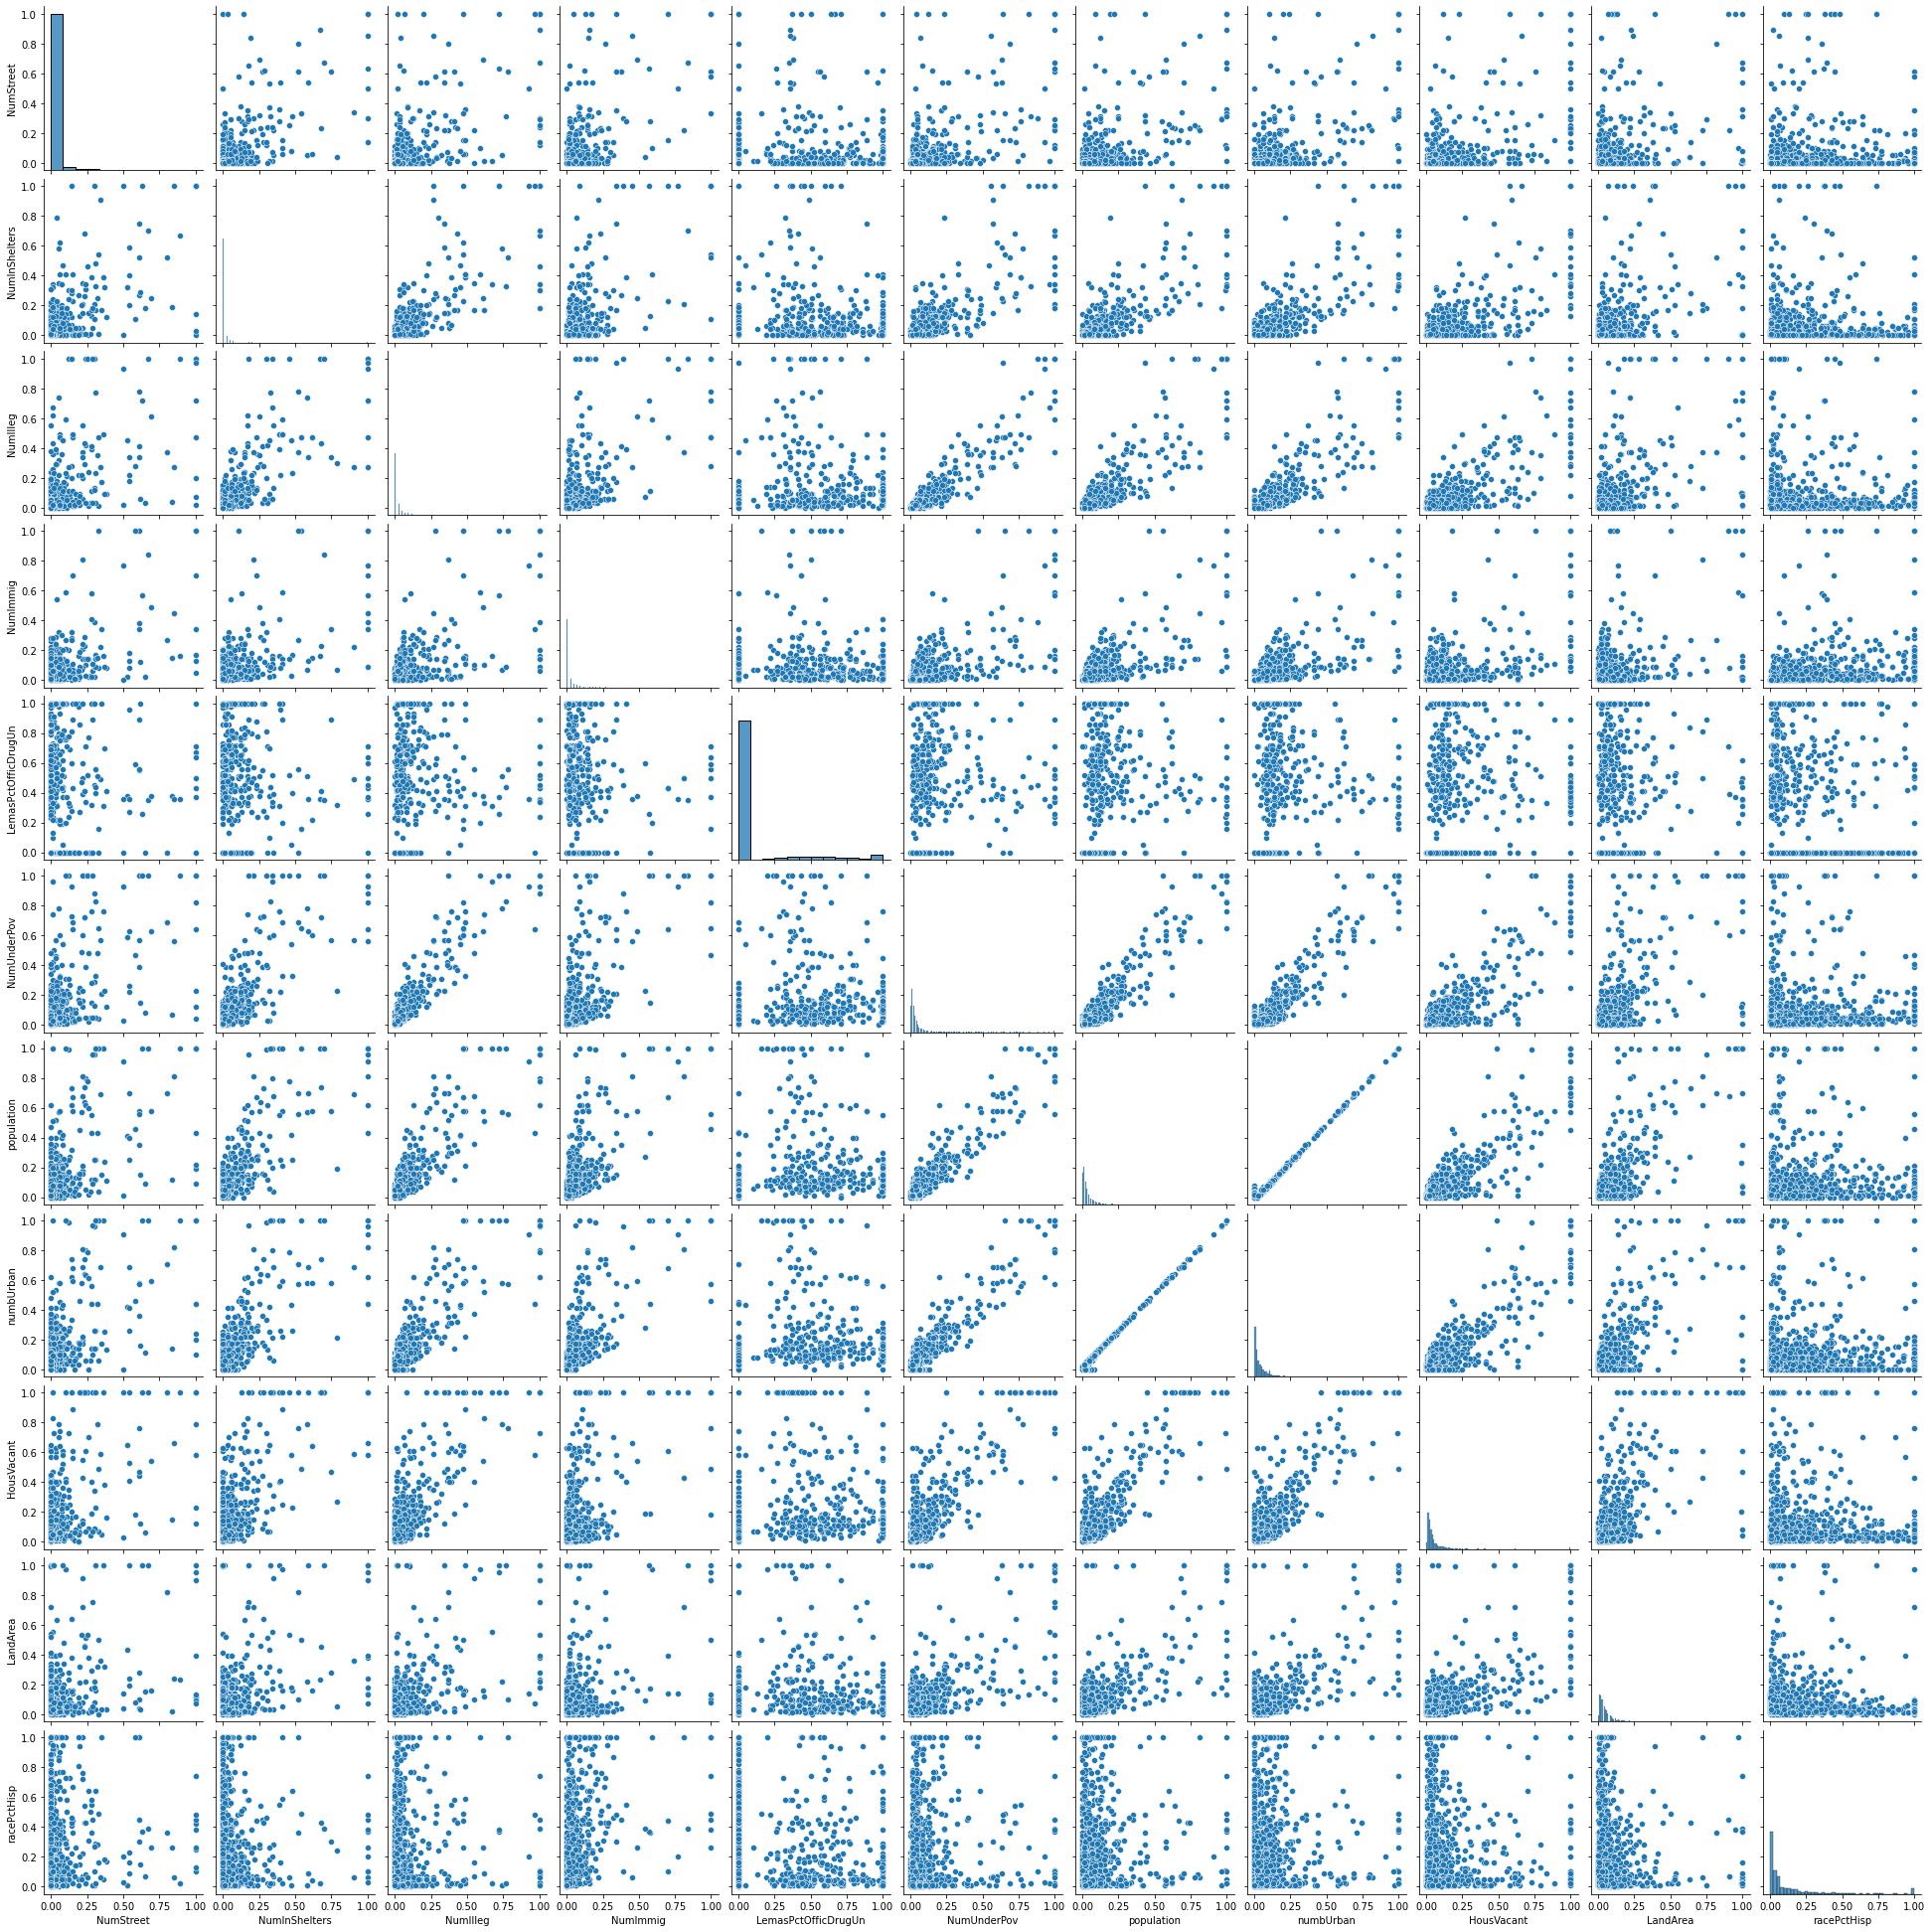

In [40]:
sns.pairplot(data[top_features])

### Box plots.

<AxesSubplot:>

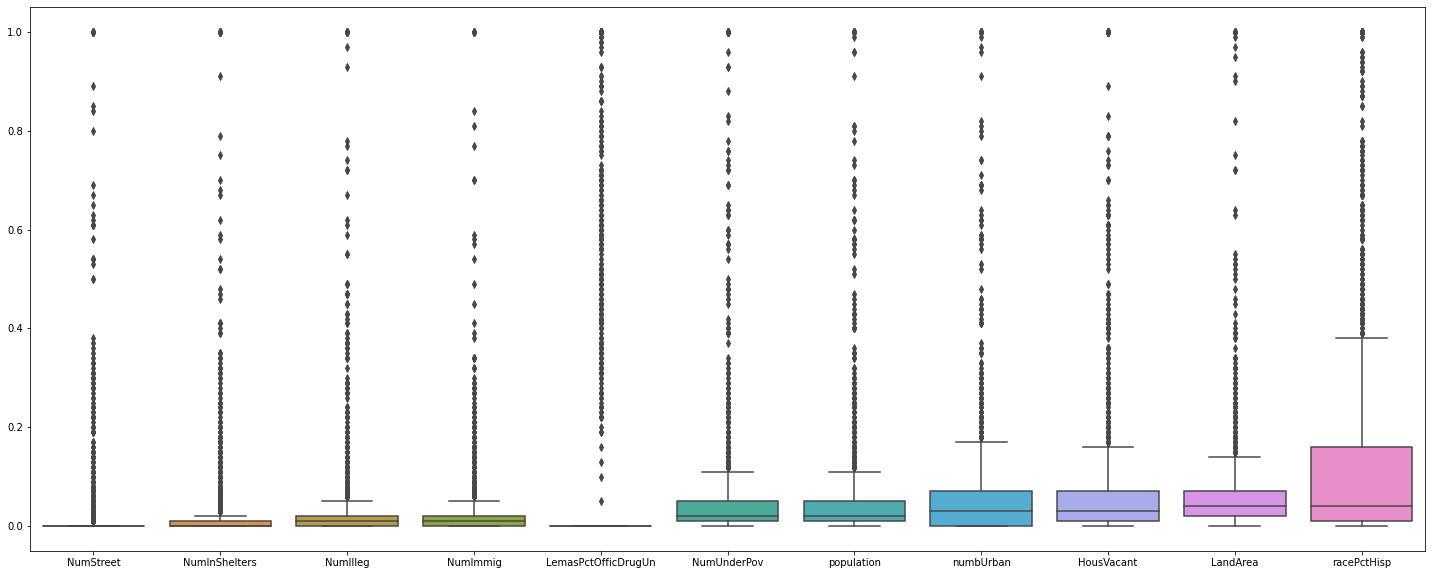

In [41]:
plt.figure(figsize=(25,10))

sns.boxplot(data=data[top_features])


### All features are considered for training

In [42]:
X,y=data.iloc[:,:-1],data['ViolentCrimesPerPop']

### Split into train and test

In [43]:
X_train,X_test=X[:1495],X[1495:]
y_train,y_test=y[:1495],y[1495:]

### 2) f) Linear regression model. High test MSE

In [44]:
##Linear regression - Least squares method
linear_regression=LinearRegression()
linear_regression=linear_regression.fit(X_train,y_train)
y_pred=linear_regression.predict(X_test)
print('test mse=',mean_squared_error(y_test,y_pred))

test mse= 0.7897255274315336


### 2) g) Ridge regresssion model. Low test MSE compared to linear regression and significant improvement

In [45]:
##Ridge regression
ridge_regression=RidgeCV()
ridge_regression=ridge_regression.fit(X_train,y_train)
y_pred=ridge_regression.predict(X_test)
print('Test Mse=',mean_squared_error(y_test,y_pred))


Test Mse= 0.017737081104294825


### 2) h) LASSO model with normalized features. Test MSE = 0.0177

In [46]:
##Lasso

##Lasso normalized
lasso_regression=LassoCV(max_iter=1500)
lasso_regression.fit(X_train,y_train)
y_pred=lasso_regression.predict(X_test)
print('Test Mse=',mean_squared_error(y_test,y_pred))

print('Chosen coefficients:')
for i in range(0,len(X.columns)):
    if lasso_regression.coef_[i]!=0:
        print(X.columns[i],':',lasso_regression.coef_[i])


Test Mse= 0.017763310017858244
Chosen coefficients:
racepctblack : 0.271989080675989
racePctAsian : -0.01548918301662082
agePct12t21 : 0.06630688001787284
agePct12t29 : -0.2650075607515013
pctUrban : 0.04051855000983897
pctWWage : -0.08474297249597243
pctWFarmSelf : 0.02656375149155791
pctWInvInc : -0.09830653093413631
pctWSocSec : 0.0485745134045852
pctWPubAsst : 0.03880390286304732
pctWRetire : -0.1084371904653559
whitePerCap : -0.057682777833476875
blackPerCap : -0.021104804881504926
indianPerCap : -0.03112233445326158
AsianPerCap : 0.02901415784655299
OtherPerCap : 0.022710891815328687
HispPerCap : 0.023937028686758288
PctPopUnderPov : -0.1412317827487068
PctLess9thGrade : -0.01816706101653411
PctEmploy : 0.13734734886136388
PctEmplManu : -0.015779994235523835
PctOccupManu : 0.010230195656756971
MalePctDivorce : 0.11814669010826678
MalePctNevMarr : 0.13327799275885222
FemalePctDiv : -0.07847575781954079
PctKids2Par : -0.19648800093601293
PctYoungKids2Par : -0.03777153855537088
PctT

### LASSO model with standardized features. Test MSE = 0.0178. Both have similar errors and standardized is slightly worse compared to normalized in this example

In [47]:
lasso_regression=LassoCV(max_iter=1500)
standard_scaler=StandardScaler()

lasso_regression.fit(standard_scaler.fit_transform(X_train),y_train)
y_pred=lasso_regression.predict(standard_scaler.transform(X_test))
print('Test Mse=',mean_squared_error(y_test,y_pred))
print('Chosen coefficients:')
for i in range(0,len(X.columns)):
    if lasso_regression.coef_[i]!=0:
        print(X.columns[i],':',lasso_regression.coef_[i])


Test Mse= 0.017810499483270535
Chosen coefficients:
racepctblack : 0.06825952168266128
racePctAsian : -0.0008869549482896286
agePct12t21 : 0.01031688701413324
agePct12t29 : -0.03818718119652618
pctUrban : 0.01659676016568195
pctWWage : -0.012031048799655266
pctWFarmSelf : 0.0040908985981578305
pctWInvInc : -0.02079862739449483
pctWSocSec : 0.008905031591624094
pctWPubAsst : 0.006134048984523406
pctWRetire : -0.01718745298772003
whitePerCap : -0.008601901094764466
blackPerCap : -0.0036486436394936057
indianPerCap : -0.00523724260081637
AsianPerCap : 0.005307444995295821
OtherPerCap : 0.003818543884901241
HispPerCap : 0.003991479136406428
PctPopUnderPov : -0.02675191102107118
PctLess9thGrade : -0.002012210216728957
PctEmploy : 0.021189855999548222
PctEmplManu : -0.001053592558372591
MalePctDivorce : 0.018987802863889174
MalePctNevMarr : 0.02070429763856106
FemalePctDiv : -0.010036031154269667
PctKids2Par : -0.03980425700074489
PctYoungKids2Par : -0.008193167704252049
PctTeen2Par : -0.001

### 2) i) PCR model. Best M is 96 without standardizing, and 95 with standardizing

In [48]:
best_m,best_score=1,0
for i in range(1,120):
    pipeline=make_pipeline( PCA(n_components=i), LinearRegression())
    scores = cross_val_score(pipeline, X_train, y_train, cv=5)
    if best_score<scores.mean():
        best_m=i
        best_score=scores.mean()

In [49]:
print(best_m,':',best_score)

96 : 0.6567210150250953


#### Test MSE is 0.018

In [50]:
## pcr with best component
pipeline=make_pipeline(StandardScaler(), PCA(n_components=i), LinearRegression())
pcr_best=pipeline.fit(X_train,y_train)
y_pred=pcr_best.predict(X_test)

print('Test MSE=',mean_squared_error(y_test,y_pred))

Test MSE= 0.018088824936628452


### j) XGBoost. Choosing alphas from 10^-4 to 10^4 and 0.25,0.5,0.75....10. Best Alpha obtained is 3.5

In [51]:
alpha_list=[10**i for i in range(-4,4)]
alpha_list+=[i/100 for i in range(25,1000,25)]
param_dict={'reg_alpha':alpha_list}
xgb_reg=xgboost.XGBRegressor()
grid_cv=GridSearchCV(xgb_reg,param_dict)
grid_cv.fit(X_train,y_train)



GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_to_o...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None, ...),
             param_grid={'reg_alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                       1000, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5,
                                       1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25,
                                       3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0,
                                       5.25, 5.5, ...]})

In [52]:
grid_cv.best_params_

{'reg_alpha': 3.5}

In [53]:
xgb_best=xgboost.XGBRegressor(reg_alpha=grid_cv.best_params_['reg_alpha'])
xgb_best.fit(X_train,y_train)
y_pred=xgb_best.predict(X_test)
print('Test MSE=',mean_squared_error(y_test,y_pred))

Test MSE= 0.017868715577723977
